<h2>Simulating a Spatial Process</h2>
<p>This simulation is created to study the applicability of spatial process convolutions for resource modelling.  Often resource estimation is broken into several stages.  A geological model is first created that attempts to define lithological structures and units in the spatial domain.  The model is refined at the domaining stage to smaller domains that are believed to control mineralization and often assumptions about variance are introduced at this stage.  Estimations are then conducted in the domains using by applying Kriging functions.</p>

<p>A convolution is fundementally a bleding of two functions.  In spatial process convolutions the functions being blended are a kernal function and a latent spatial process which is represented by weights.</p>

<h3>Regularily Spaced</h3>
<p>Grid points have both a categorical predictor and continuous predictor.</p>

Text(0.5, 1.0, 'Spatial domain')

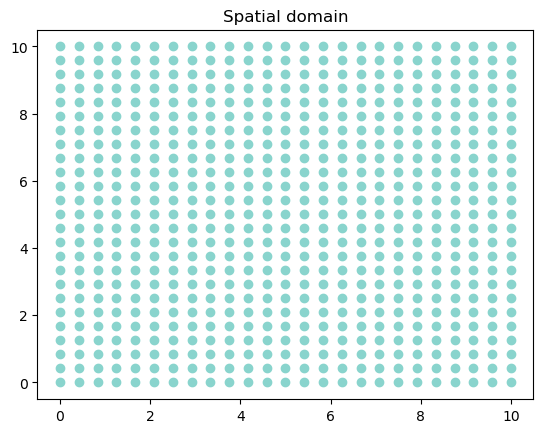

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt

#Define the spatial domain
n_points_X = 25
n_points_Y = 25

x = np.linspace(0, 10, n_points_X)
y = np.linspace(0, 10, n_points_Y)
X, Y = np.meshgrid(x, y)
locations = np.column_stack([X.ravel(), Y.ravel()])  #Shared locations
num_locations = len(locations)

plt.scatter(locations[:, 0], locations[:, 1], c="#89d4cd")
plt.title("Spatial domain")

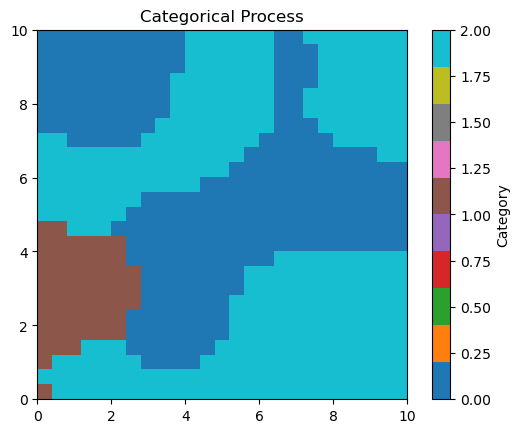

In [2]:
#Kernel function
def gaussian_kernel(locations, range=1.0, variance=1.0):
    distances = cdist(locations, locations, metric="euclidean")
    return variance * np.exp(-0.5 * (distances / range) ** 2)

#Parameters for kernels
k = 3  #Number of categories
range_cat = 2
range_cont = 2
variance_cat = 2
variance_cont = 2

#Step 1: Simulate the categorical process
cov_cat = gaussian_kernel(locations=locations, range=range_cat, variance=variance_cat)
gp_samples_cat = np.random.multivariate_normal(mean=np.zeros(num_locations), cov=cov_cat, size=k)
gp_stacked = np.stack(gp_samples_cat, axis=-1)
categories = np.argmax(gp_stacked, axis=-1).reshape(n_points_X, n_points_Y)  #2D array of categories

#Visualize the categorical process
plt.imshow(categories, extent=(0, 10, 0, 10), origin='lower', cmap="tab10")
plt.title("Categorical Process")
plt.colorbar(label="Category")
plt.show()

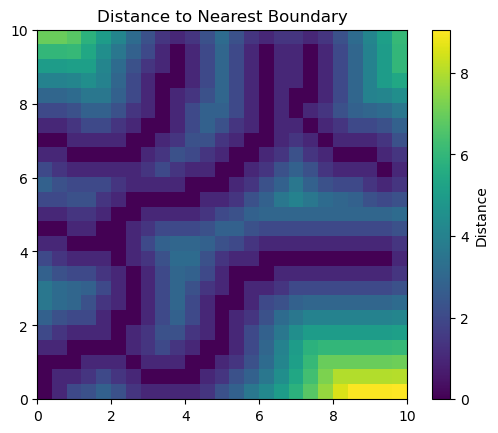

In [3]:
#Step 2: Compute distance to boundaries
#Compute a boundary mask
boundary_mask = np.zeros_like(categories, dtype=bool)

for i in range(categories.shape[0] - 1):
    for j in range(categories.shape[1] - 1):
        if categories[i, j] != categories[i + 1, j] or categories[i, j] != categories[i, j + 1]:
            boundary_mask[i, j] = True

#Compute distances to the nearest boundary
distances_to_boundary = distance_transform_edt(~boundary_mask)

# Visualize distances to boundaries
plt.imshow(distances_to_boundary, extent=(0, 10, 0, 10), origin="lower", cmap="viridis")
plt.title("Distance to Nearest Boundary")
plt.colorbar(label="Distance")
plt.show()


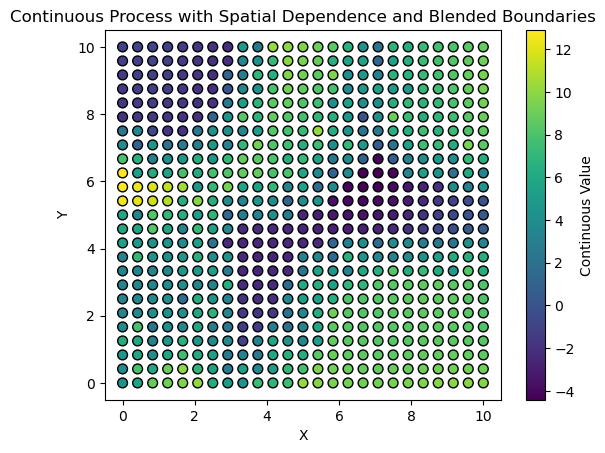

In [4]:
# Step 3: Simulate the continuous process with blending
# Define category-specific parameters
mean_vector = [0, 5, 10]  # Means for each category
variance_vector = [1, 2, 1.5]  # Variances for each category

continuous_values = np.zeros(num_locations)

alpha = 1.0  # Controls blending sharpness
blending_threshold = 2  # Distance threshold for blending

# Simulate a spatially correlated field for each category
cov_cont = gaussian_kernel(locations, range=range_cont, variance=variance_cont)
spatial_fields = np.random.multivariate_normal(mean=np.zeros(num_locations), cov=cov_cont, size=k)

for i in range(num_locations):
    # Get the category for the current location
    assigned_category = categories.ravel()[i]

    # Compute the base mean and variance based on the assigned category
    base_mean = mean_vector[assigned_category]
    base_variance = variance_vector[assigned_category]

    # Compute distance to the nearest boundary
    dist_to_boundary = distances_to_boundary.ravel()[i]

    # Blending near the boundary
    if dist_to_boundary < blending_threshold:  # Blending region
        # Compute weights for blending with other categories
        blended_mean = 0
        blended_variance = 0
        total_weight = 0
        for cat in range(k):  # Blend contributions from all categories
            weight = np.exp(-alpha * dist_to_boundary if cat != assigned_category else 0)
            blended_mean += weight * mean_vector[cat]
            blended_variance += weight * variance_vector[cat]
            total_weight += weight
        blended_mean /= total_weight
        blended_variance /= total_weight

        # Sample from the blended distribution
        continuous_values[i] = np.random.normal(blended_mean, np.sqrt(blended_variance))
    else:  # Outside blending threshold: use spatially correlated field
        continuous_values[i] = spatial_fields[assigned_category, i] + base_mean

# Visualize the continuous process
plt.scatter(locations[:, 0], locations[:, 1], c=continuous_values, cmap="viridis", s=50, edgecolor="k")
plt.title("Continuous Process with Spatial Dependence and Blended Boundaries")
plt.colorbar(label="Continuous Value")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

<h2>More realistic</h2>
<p>This spatial process simulator does not require that categorical and continuous processes are at the same locations</p>

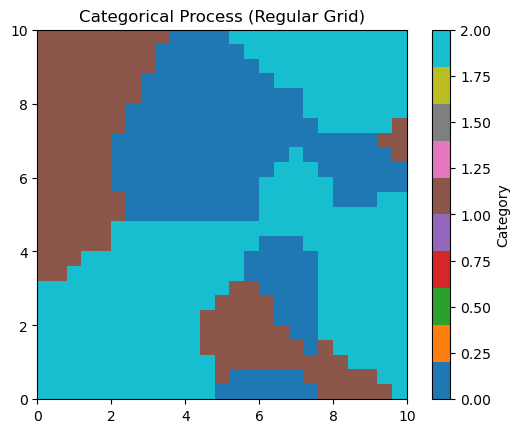

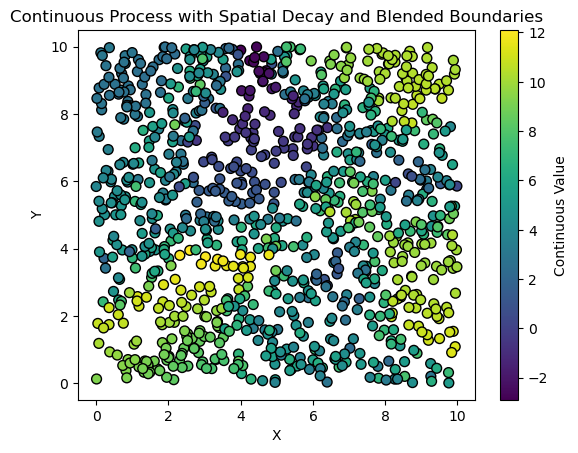

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt

#Define the spatial domain for the categorical process
n_points_X = 25
n_points_Y = 25
x = np.linspace(0, 10, n_points_X)
y = np.linspace(0, 10, n_points_Y)
X, Y = np.meshgrid(x, y)
locations_cat = np.column_stack([X.ravel(), Y.ravel()])  #Grid locations

#Generate random points for the continuous process
num_random_points = 1000
random_x = np.random.uniform(0, 10, num_random_points)
random_y = np.random.uniform(0, 10, num_random_points)
locations_cont = np.column_stack([random_x, random_y])  #Scattered points

#Kernel function
def gaussian_kernel(locations, range=1.0, variance=1.0):
    distances = cdist(locations, locations, metric="euclidean")
    return variance * np.exp(-0.5 * (distances / range) ** 2)

#Step 1: Simulate the categorical process
k = 3  # Number of categories
range_cat = 2
variance_cat = 2
cov_cat = gaussian_kernel(locations=locations_cat, range=range_cat, variance=variance_cat)
gp_samples_cat = np.random.multivariate_normal(mean=np.zeros(len(locations_cat)), cov=cov_cat, size=k)
gp_stacked = np.stack(gp_samples_cat, axis=-1)
categories = np.argmax(gp_stacked, axis=-1).reshape(n_points_X, n_points_Y)  # 2D grid of categories

#Visualize the categorical process
plt.imshow(categories, extent=(0, 10, 0, 10), origin="lower", cmap="tab10")
plt.title("Categorical Process (Regular Grid)")
plt.colorbar(label="Category")
plt.show()

#Step 2: Compute distance to category boundaries (grid-based)
boundary_mask = np.zeros_like(categories, dtype=bool)
for i in range(categories.shape[0] - 1):
    for j in range(categories.shape[1] - 1):
        if categories[i, j] != categories[i + 1, j] or categories[i, j] != categories[i, j + 1]:
            boundary_mask[i, j] = True
distances_to_boundary = distance_transform_edt(~boundary_mask).ravel()

#Assign categories to scattered points (nearest neighbor on the grid)
dist_to_grid = cdist(locations_cont, locations_cat)
closest_grid_indices = np.argmin(dist_to_grid, axis=1)
assigned_categories = categories.ravel()[closest_grid_indices]

#Step 3: Simulate a spatially correlated field for the continuous process
range_cont = 2
variance_cont = 1
cov_cont = gaussian_kernel(locations_cont, range=range_cont, variance=variance_cont)
spatial_field = np.random.multivariate_normal(mean=np.zeros(num_random_points), cov=cov_cont)

#Define category-specific parameters
mean_vector = [0, 5, 10]  #Means for each category
variance_vector = [1, 2, 1.5]  #Variances for each category

#Simulate the continuous process at scattered points
continuous_values = np.zeros(num_random_points)
alpha = 1.0  # Controls blending sharpness
blending_threshold = 2  # Distance threshold for blending

for i in range(num_random_points):
    #Compute distance to the nearest boundary
    dist_to_boundary = distances_to_boundary[closest_grid_indices[i]]
    assigned_category = assigned_categories[i]

    if dist_to_boundary < blending_threshold:  #Inside blending region
        #Compute weights for blending with other categories
        blended_mean = 0
        blended_variance = 0
        total_weight = 0
        for cat in range(k):  #Blend contributions from all categories
            weight = np.exp(-alpha * dist_to_boundary if cat != assigned_category else 0)
            blended_mean += weight * mean_vector[cat]
            blended_variance += weight * variance_vector[cat]
            total_weight += weight
        blended_mean /= total_weight
        blended_variance /= total_weight

        #Sample from the blended distribution
        continuous_values[i] = np.random.normal(blended_mean, np.sqrt(blended_variance))
    else:  #Outside blending region: Use spatially correlated field
        continuous_values[i] = spatial_field[i] + mean_vector[assigned_category]

#Step 4: Visualize the continuous process (scattered points)
plt.scatter(random_x, random_y, c=continuous_values, cmap="viridis", s=50, edgecolor="k")
plt.title("Continuous Process with Spatial Decay and Blended Boundaries")
plt.colorbar(label="Continuous Value")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
